In [19]:
import os
import pandas as pd
import requests
import zipfile
from urllib.parse import urljoin
from bs4 import BeautifulSoup

ETL

Extraccion

In [20]:
import os

def download_file(url, path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(path, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
    return path

def unzip_and_remove(zip_path, destination_directory):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_directory)
    os.remove(zip_path)

def scrape_and_download(base_url, start_year=2000):
    if not os.path.exists('Bases_calidad_aire'):
        os.makedirs('Bases_calidad_aire')

    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = soup.find_all('a')

    for link in links:
        href = link.get('href')
        if href and 'annual_conc_by_monitor' in href and href.endswith('.zip'):
            year = href.split('_')[-1].split('.')[0]
            try:
                year = int(year)
                if year >= start_year:
                    download_url = urljoin(base_url, href)
                    zip_path = os.path.join('Bases_calidad_aire', href)
                    extracted_file_path = os.path.join('Bases_calidad_aire', href.replace('.zip', '.csv'))

                    # Verificar si el archivo CSV extraído ya existe
                    if not os.path.exists(extracted_file_path):
                        if not os.path.exists(zip_path):
                            print(f'Descargando {download_url}...')
                            download_file(download_url, zip_path)
                            print(f'Descargado en {zip_path}')

                        print(f'Descomprimiendo {zip_path}...')
                        unzip_and_remove(zip_path, 'Bases_calidad_aire')
                        print(f'Descomprimido y eliminado {zip_path}')
                    else:
                        print(f'Archivo {extracted_file_path} ya existe. Saltando descarga y descompresión.')
                else:
                    print(f'El año {year} es anterior al año de inicio {start_year}. Saltando descarga.')
            except ValueError:
                pass


Transformacion

In [21]:
def load_original_data(file_path):
    df = pd.read_csv(file_path)
    return df

def transform_data(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    processed_dfs = []
    for csv_file in csv_files:
        file_path = os.path.join(directory, csv_file)
        try:
            df = load_original_data(file_path)
            processed_dfs.append(df)
        except Exception as e:
            print(f"Error procesando {csv_file}: {e}")

    combined_df = pd.concat(processed_dfs, ignore_index=True)

    parameter_name_criteria = ["PM2.5 - Local Conditions", "Ozone"]
    metric_used_criteria = "Observed Values"

    filtered_df = combined_df[(combined_df['Parameter Name'].isin(parameter_name_criteria)) & (combined_df['Metric Used'] == metric_used_criteria)]

    collapsed_df = filtered_df.pivot_table(
        index=['Year', 'State Name'],
        columns='Parameter Name',
        values='Arithmetic Mean',
        aggfunc='mean'
    ).reset_index()

    collapsed_df.columns.name = None
    collapsed_df = collapsed_df.rename(columns={
        "PM2.5 - Local Conditions": "PM2.5 Mean",
        "Ozone": "Ozone Mean"
    })

    return collapsed_df

carga

In [22]:
def save_transformed_data(data, filename):
    data.to_csv(filename, index=False)


moddelo

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_model(data, states_to_forecast, arima_order, forecast_years):
    evaluation_metrics = {}
    forecast_results = {}

    for state in states_to_forecast:
        # Filtrar los datos por estado
        data_state = data[data['State Name'] == state].set_index('Year')

        # Ajustar el modelo ARIMA
        model = SARIMAX(data_state['PM2.5 Mean'], order=arima_order, seasonal_order=(0, 0, 0, 0))
        model_fit = model.fit()

        # Generar pronóstico
        forecast = model_fit.get_forecast(steps=forecast_years)
        forecast_index = pd.date_range(start=str(data_state.index[-1] + 1), periods=forecast_years, freq='AS')
        forecast_mean = forecast.predicted_mean
        forecast_conf_int = forecast.conf_int()
        forecast_mean.index = forecast_index.year
        forecast_conf_int.index = forecast_index.year

        # Calcular métricas de evaluación
        aic = model_fit.aic
        bic = model_fit.bic
        mse = mean_squared_error(data_state['PM2.5 Mean'][1:], model_fit.fittedvalues[1:])

        evaluation_metrics[state] = {'AIC': aic, 'BIC': bic, 'MSE': mse}
        forecast_results[state] = {'Forecast Mean': forecast_mean, 'Forecast Confidence Interval': forecast_conf_int}

        # Visualización (opcional)
        plt.figure(figsize=(12, 6))
        plt.plot(data_state.index, data_state['PM2.5 Mean'], label='Historical Data', marker='o')
        plt.plot(forecast_index.year, forecast_mean, label='Forecast', color='red', marker='o')
        plt.fill_between(forecast_index.year, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(f'ARIMA Forecast of PM2.5 Mean in {state} for the Next {forecast_years} Years')
        plt.xlabel('Year')
        plt.ylabel('PM2.5 Mean')
        plt.legend()
        plt.xticks(np.arange(data_state.index.min(), forecast_index.year.max() + 1, 1))  # Set x-ticks to show every year
        plt.grid(True)
        plt.show()

    return evaluation_metrics, forecast_results


main

Archivo Bases_calidad_aire\annual_conc_by_monitor_2023.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2022.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2021.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2020.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2019.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2018.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2017.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2016.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2015.csv ya existe. Saltando descarga y descompresión.
Archivo Bases_calidad_aire\annual_conc_by_monitor_2014.

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_12728\3431135601.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_12728\3431135601.py:2: DtypeWarning: Columns (0,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_12728\3431135601.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_12728\3431135601.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_12728\3431135601.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:

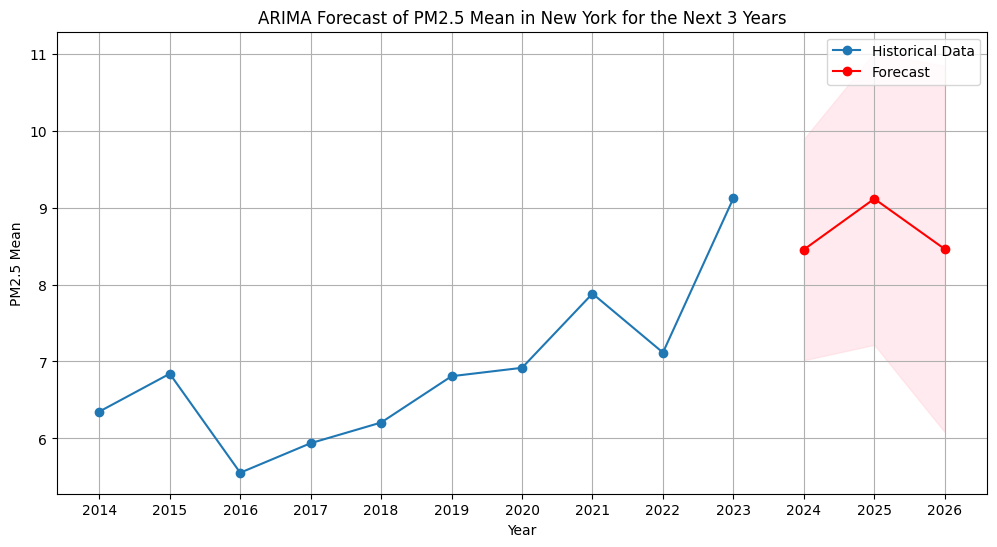

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Eduardo\AppDa

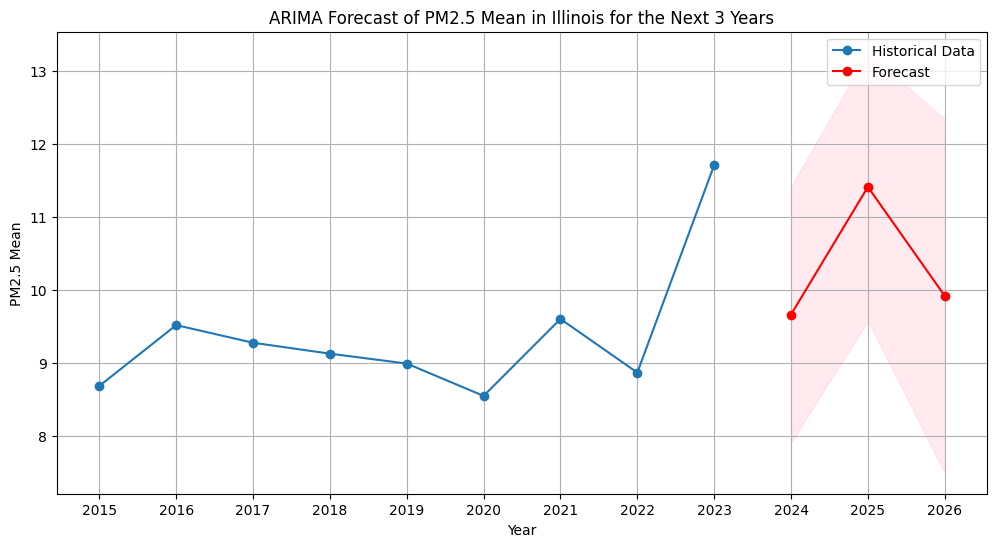

In [24]:
def main_etl_and_model(base_url, output_filename, states_to_forecast, arima_order, forecast_years):
    scrape_and_download(base_url)
    transformed_data = transform_data('Bases_calidad_aire')
    save_transformed_data(transformed_data, output_filename)
    metrics, forecasts = run_model(transformed_data, states_to_forecast, arima_order, forecast_years)
    return metrics, forecasts

# Ejemplo de cómo llamar a la función principal
base_url = 'https://aqs.epa.gov/aqsweb/airdata/download_files.html'
output_filename = "pollution_year_state.csv"
states_to_forecast = ['New York', 'Illinois']
arima_order = (1, 1, 1)  # Ejemplo, necesitas definir esto basado en tu análisis
forecast_years = 3
metrics, forecasts = main_etl_and_model(base_url, output_filename, states_to_forecast, arima_order, forecast_years)
